<a href="https://colab.research.google.com/github/mattia01017/CNN-cell-segmentation/blob/main/CNNcellSegm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project: CNN-based segmentation of cells in multi-modal microscopy images

Contact: Karl Rohr (Heidelberg University K.Rohr@dkfz-heidelberg.de)

### Introduction

Cell segmentation is a central task in biomedical image analysis and enables counting the cell number, quantifying single-cell fluorescence intensity, and tracking of cells to analyze cell motion. Challenges are high variation of cell shape and image intensity, strong image noise, low image contrast, and high cell density. Deep learning methods for cell segmentation in microscopy data show promising results.

### Goal

The goal of this project is to develop a Convolutional Neural Network (CNN) to automatically segment cells in microscopy images. A modified 2D U-Net model (Ronneberger et al., MICCAI 2015, Falk et al., Nature Methods 2019) will be implemented and applied to image data from different imaging modalities comprising fluorescence, differential interference contrast (DIC), and phase-contrast microscopy. Different versions of the network model will be generated by training on data from individual imaging modalities as well as a combination of different imaging modalities. The trained models are applied to the different datasets, and the segmentation accuracy will be quantified by a performance metric. The experimental results are analyzed and a comparison of the different network models will be carried out.

### Data and model

The [2D U-Net model](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) will be used as a basis. Zero-padding (SAME padding) in the convolution layers should be included to ensure that the output size of the network is the same as the input size. This eliminates the need for cropping and resizing of the images in the original model. Experiments with different network configurations should be performed (e.g., different number of layers). Besides using a Cross-Entropy Loss as in the original model, a Dice Loss or a combination of both losses should be investigated. Also, loss weighting as in the original model should be tested. Existing implementations of the U-Net can be used as inspiration.

The network model should be applied to [datasets from the Cell Tracking Challenge](https://celltrackingchallenge.net/2d-datasets/) (Ulman et al., Nature Methods 2017) comprising 2D time-lapse microscopy image data of three different imaging modalities:
1. Fluorescence microscopy: HeLa cells stably expressing H2b-GFP ([download](http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DL-HeLa.zip))
2. Differential interference contrast (DIC) microscopy: HeLa cells on a flat glass ([download](http://data.celltrackingchallenge.net/training-datasets/DIC-C2DH-HeLa.zip))
3. Phase-contrast microscopy: Glioblastoma-astrocytoma U373 cells on a polyacrylamide substrate ([download](http://data.celltrackingchallenge.net/training-datasets/PhC-C2DH-U373.zip))

Each dataset consists of two image sequences from which single images should be used as samples. The images can be found in the folders `01` and `02`. Since the "gold truth" provided in the folders `01_GT/SEG` and `02_GT/SEG` is not available for all single images or cells, the "silver truth" in `01_ST/SEG` or `02_ST/SEG`can be used. More information on the datasets can be found [here](https://celltrackingchallenge.net/). One of the two image sequences should be used for training and the other for testing. The labels are instance labels (with a different ID for each cell), which need to be converted to semantic labels (foreground-background).

Different versions of the network model should be generated by training on data from individual imaging modalities as well as a combination of different imaging modalities. A comparison of the different network models should be performed. The Jaccard Index (Intersection over Union) can be used as segmentation performance metric. A strategy needs to be found to deal with large image sizes (e.g., using image resizing or image tiling as in the original model). To improve the segmentation result, different preprocessing and data augmentation strategies can be studied. Information on deep learning for image segmentation and the U-Net is provided in the lecture (Karl Rohr).


### References
Ronneberger 0, Fischer P, Brox T. (2015) [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28), MICCAI 2015, 234–241

Falk T, Brox T, Ronneberger O et al. (2019) [U-Net: deep learning for cell counting, detection, and morphometry](https://www.nature.com/articles/s41592-018-0261-2), Nature Methods 16, 67-70

Ulman V, Maška M, Harder N, Rohr K, Kozubek M, Ortiz-de-Solorzano C, et al. (2017) [An objective comparison of cell-tracking algorithms](https://www.nature.com/articles/nmeth.4473), Nature Methods 14, 1141–1152




---

# Setup and dataset download

In [1]:
!pip install imagecodecs
!curl https://data.celltrackingchallenge.net/training-datasets/Fluo-N2DL-HeLa.zip -o Fluo-N2DL-HeLa.zip
!curl https://data.celltrackingchallenge.net/training-datasets/DIC-C2DH-HeLa.zip -o DIC-C2DH-HeLa.zip
!curl https://data.celltrackingchallenge.net/training-datasets/PhC-C2DH-U373.zip -o PhC-C2DH-U373.zip
!unzip Fluo-N2DL-HeLa.zip > /dev/null
!unzip DIC-C2DH-HeLa.zip > /dev/null
!unzip PhC-C2DH-U373.zip > /dev/null
!rm *.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 17.4 MB/s eta 0:00:00
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  190M  100  190M    0     0  17.2M      0  0:00:11  0:00:11 --:--:-- 21.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39.5M  100 39.5M    0     0  11.9M      0  0:00:03  0:00:03 --:--:-- 11.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41.4M  100 41.4M    0     0  11.8M      0  0:00:03  0:00:03 --:--:-- 11.8M


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import scipy.ndimage
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.transforms import *
from torchvision.io import read_image
from skimage.transform import resize
from pathlib import Path

# for reproducibility
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Network will run on '{device}'.")


def load_images(path: Path):
  return np.stack([
      skimage.io.imread(fn)
      for fn in sorted(path.glob("*.tif"))
  ])


def get_slices(dataset_shape, patch_size, stride):
    x, y = dataset_shape
    p_x, p_y = patch_size
    s_x, s_y = stride

    x_indices = np.arange(0, x - p_x + 1, s_x)
    if x_indices[-1] + p_x < x:
        x_indices = np.append(x_indices, x - p_x)

    y_indices = np.arange(0, y - p_y + 1, s_y)
    if y_indices[-1] + p_y < y:
        y_indices = np.append(y_indices, y - p_y)

    slices = []
    for idx_x in x_indices:
        for idx_y in y_indices:
            slices.append((
                slice(idx_x, idx_x + p_x),
                slice(idx_y, idx_y + p_y)
            ))
    return slices


def plot_img(ax, data, title=""):
  ax.imshow(data, cmap="grey")
  ax.set_title(title)
  ax.axis("off")


def plot_mask(ax, data, title=""):
  random_state = np.random.RandomState(0)
  colors = [(0,0,0)] + [(random_state.random(),random_state.random(),random_state.random()) for _ in np.unique(data)]
  random_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("random_cmap", colors)
  ax.imshow(data, cmap=random_cmap,  interpolation="nearest")
  ax.set_title(title)
  ax.axis("off")

Network will run on 'cpu'.


# Dataset import

We define a dataset for each image. A dataset will contain slices of the same image, possibly with a transformation applied

In [45]:
class CellImageDataset(Dataset):
  def __init__(self,
                 image,
                 label,
                 patch_size,
                 stride,
                 padding,
                 image_transformer,
                 label_transformer,
                 phase):
    super().__init__()
    self.phase = phase

    self.image_transformer = image_transformer
    self.label_transformer = label_transformer

    self.image = image
    self.label = label

    self.image_shape = self.image.shape
    if padding is not None:
        self.image = np.pad(self.image, pad_width=((padding[0], padding[0]), (padding[1], padding[1])), mode="reflect")
        self.label = np.pad(self.label, pad_width=((padding[0], padding[0]), (padding[1], padding[1])), mode="reflect")

    self.slices = get_slices(self.image.shape, patch_size, stride)

  def __len__(self,):
      return len(self.slices)

  def __getitem__(self, index):
      sl = self.slices[index]

      x = self.image[sl]
      y = self.label[sl]

      x = self.image_transformer(x)
      y = self.label_transformer(y)

      if self.phase == "test":
          return x[0], y[0], sl
      else:
          return x[0], y[0]


def load_datasets(path: Path, phase, **dataset_args):
    if phase == "train":
        img_dir = path / "01"
        labels_dir = path / "01_ST" / "SEG"
    elif phase == "test":
        img_dir = path / "02"
        labels_dir = path / "02_ST" / "SEG"

    return ConcatDataset([
        CellImageDataset(
            image=image,
            label=label,
            phase=phase,
            **dataset_args
        )
        for image, label in zip(load_images(img_dir), load_images(labels_dir))
    ])

Below the transformation methods, applied to an image with a given probability

In [4]:
def cast(type_):
  return lambda x: x.astype(type_)

def to_tensor():
  return lambda x: (
       torch.from_numpy(x.copy()).unsqueeze(0)
       if len(x.shape) == 2
       else torch.from_numpy(x.copy())
  )

def normalize(min=None, max=None, eps=1e-8):
  return lambda x: (x - min) / (max - min + eps) if min is not None and max is not None else (x - x.min()) / (x.max() - x.min() + eps)

def instance2Semantic():
  return lambda x: (x > 0).astype(int)

def rotate_90(random_state, execution_probability=0.0):
  def inner(x):
    if random_state.random() < execution_probability:
      k = random_state.randint(1,4)
      return np.rot90(x,k)
    return x
  return inner

def contrast(random_state, scale, execution_probability=0.0):
    def inner(x):
      if random_state.random() < execution_probability:
        lam = random_state.uniform(np.max((0, 1 - scale)), 1 + scale)
        return np.clip(x * lam, 0, 255)
      return x
    return inner

def brightness(random_state, scale, execution_probability=0.0):
  def inner(x):
    if random_state.random() < execution_probability:
      lam = 255 * scale * random_state.uniform(-1,1)
      return np.clip(x + lam, 0, 255)
    return x
  return inner

def elastic_deformation(random_state, grid_size, sigma, order, execution_probability=0.0):
  def inner(x):
    if random_state.random() < execution_probability:
      h,w = x.shape

      dx = random_state.randn(*[grid_size, grid_size]) * sigma
      dy = random_state.randn(*[grid_size, grid_size]) * sigma

      dx = resize(dx, x.shape, preserve_range=True, order = 3)
      dy = resize(dy, x.shape, preserve_range=True, order = 3)

      idx_x, idx_y = np.meshgrid(np.arange(h), np.arange(w))

      coordinates = idx_y + dy, idx_x + dx

      return scipy.ndimage.map_coordinates(x, coordinates, order = order, mode = "reflect", prefilter=False)
    return x
  return inner

def flip(random_state, execution_probability=0.0):
  def inner(x):
    if random_state.random() < execution_probability:
      return np.flip(x, 1 if random_state.random() < 0.5 else 0)
    return x
  return inner

def rotate(random_state, angle_range, execution_probability=0.0, mode="mirror", order=0, reshape=False):
  def inner(x):
    if random_state.random() < execution_probability:
      return scipy.ndimage.rotate(x, random_state.uniform(angle_range[0], angle_range[1]), mode=mode, order=order, reshape=reshape)
    return x
  return inner

In [12]:
execution_probability = 0.1
image_transforms_train = Compose([
    cast(np.float32),
    rotate_90(random_state=np.random.RandomState(random_seed), execution_probability=execution_probability),
    rotate(random_state=np.random.RandomState(random_seed), angle_range=[-10,10], execution_probability=execution_probability, order=2),
    flip(random_state=np.random.RandomState(random_seed), execution_probability=execution_probability),
    elastic_deformation(random_state=np.random.RandomState(random_seed), grid_size=3, sigma=10, order=3, execution_probability=execution_probability),
    contrast(random_state=np.random.RandomState(random_seed), scale=0.1, execution_probability=execution_probability),
    brightness(random_state=np.random.RandomState(random_seed), scale=0.1, execution_probability=execution_probability),
    normalize(min=0, max=255),
    to_tensor()
])

label_transforms_train = Compose([
    instance2Semantic(),
    rotate_90(random_state=np.random.RandomState(random_seed), execution_probability=execution_probability),
    rotate(random_state=np.random.RandomState(random_seed), angle_range=[-10,10], execution_probability=execution_probability, order=0),
    flip(random_state=np.random.RandomState(random_seed), execution_probability=execution_probability),
    elastic_deformation(random_state=np.random.RandomState(random_seed), grid_size=3, sigma=10, order=1, execution_probability=execution_probability),
    to_tensor()
])

image_transforms_test = Compose([
    cast(np.float32),
    normalize(min=0, max=255),
    to_tensor()
])
label_transforms_test = Compose([
    instance2Semantic(),
    to_tensor()
])

Here we import the data and create the data loaders

In [ ]:
batch_size = 64
patch_size = (128,128)
stride = (64,64)
padding = (0,0)

fluo_data = {
    "train": DataLoader(
        load_datasets(
            Path("Fluo-N2DL-HeLa"),
            phase="train",
            patch_size=patch_size,
            stride=stride,
            padding=padding,
            image_transformer=image_transforms_train,
            label_transformer=label_transforms_train,
        ),
        batch_size=batch_size,
        shuffle=True,
    ),
    "test": DataLoader(
        load_datasets(
            Path("Fluo-N2DL-HeLa"),
            phase="test",
            patch_size=patch_size,
            stride=stride,
            padding=padding,
            image_transformer=image_transforms_test,
            label_transformer=label_transforms_test,
        ),
        batch_size=batch_size,
        shuffle=True,
    ),
}

phc_data = {
    "train": DataLoader(
        load_datasets(
            Path("PhC-C2DH-U373"),
            phase="train",
            patch_size=patch_size,
            stride=stride,
            padding=padding,
            image_transformer=image_transforms_train,
            label_transformer=label_transforms_train,
        ),
        batch_size=batch_size,
        shuffle=True,
    ),
    "test": DataLoader(
        load_datasets(
            Path("PhC-C2DH-U373"),
            phase="test",
            patch_size=patch_size,
            stride=stride,
            padding=padding,
            image_transformer=image_transforms_test,
            label_transformer=label_transforms_test,
        ),
        batch_size=batch_size,
        shuffle=True,
    ),
}

dic_data = {
    "train": DataLoader(
        load_datasets(
            Path("DIC-C2DH-HeLa"),
            phase="train",
            patch_size=patch_size,
            stride=stride,
            padding=padding,
            image_transformer=image_transforms_train,
            label_transformer=label_transforms_train,
        ),
        batch_size=batch_size,
        shuffle=True,
    ),
    "test": DataLoader(
        load_datasets(
            Path("DIC-C2DH-HeLa"),
            phase="test",
            patch_size=patch_size,
            stride=stride,
            padding=padding,
            image_transformer=image_transforms_test,
            label_transformer=label_transforms_test,
        ),
        batch_size=batch_size,
        shuffle=True,
    ),
}

Below the plots of some examples took from each of the 3 given datasets

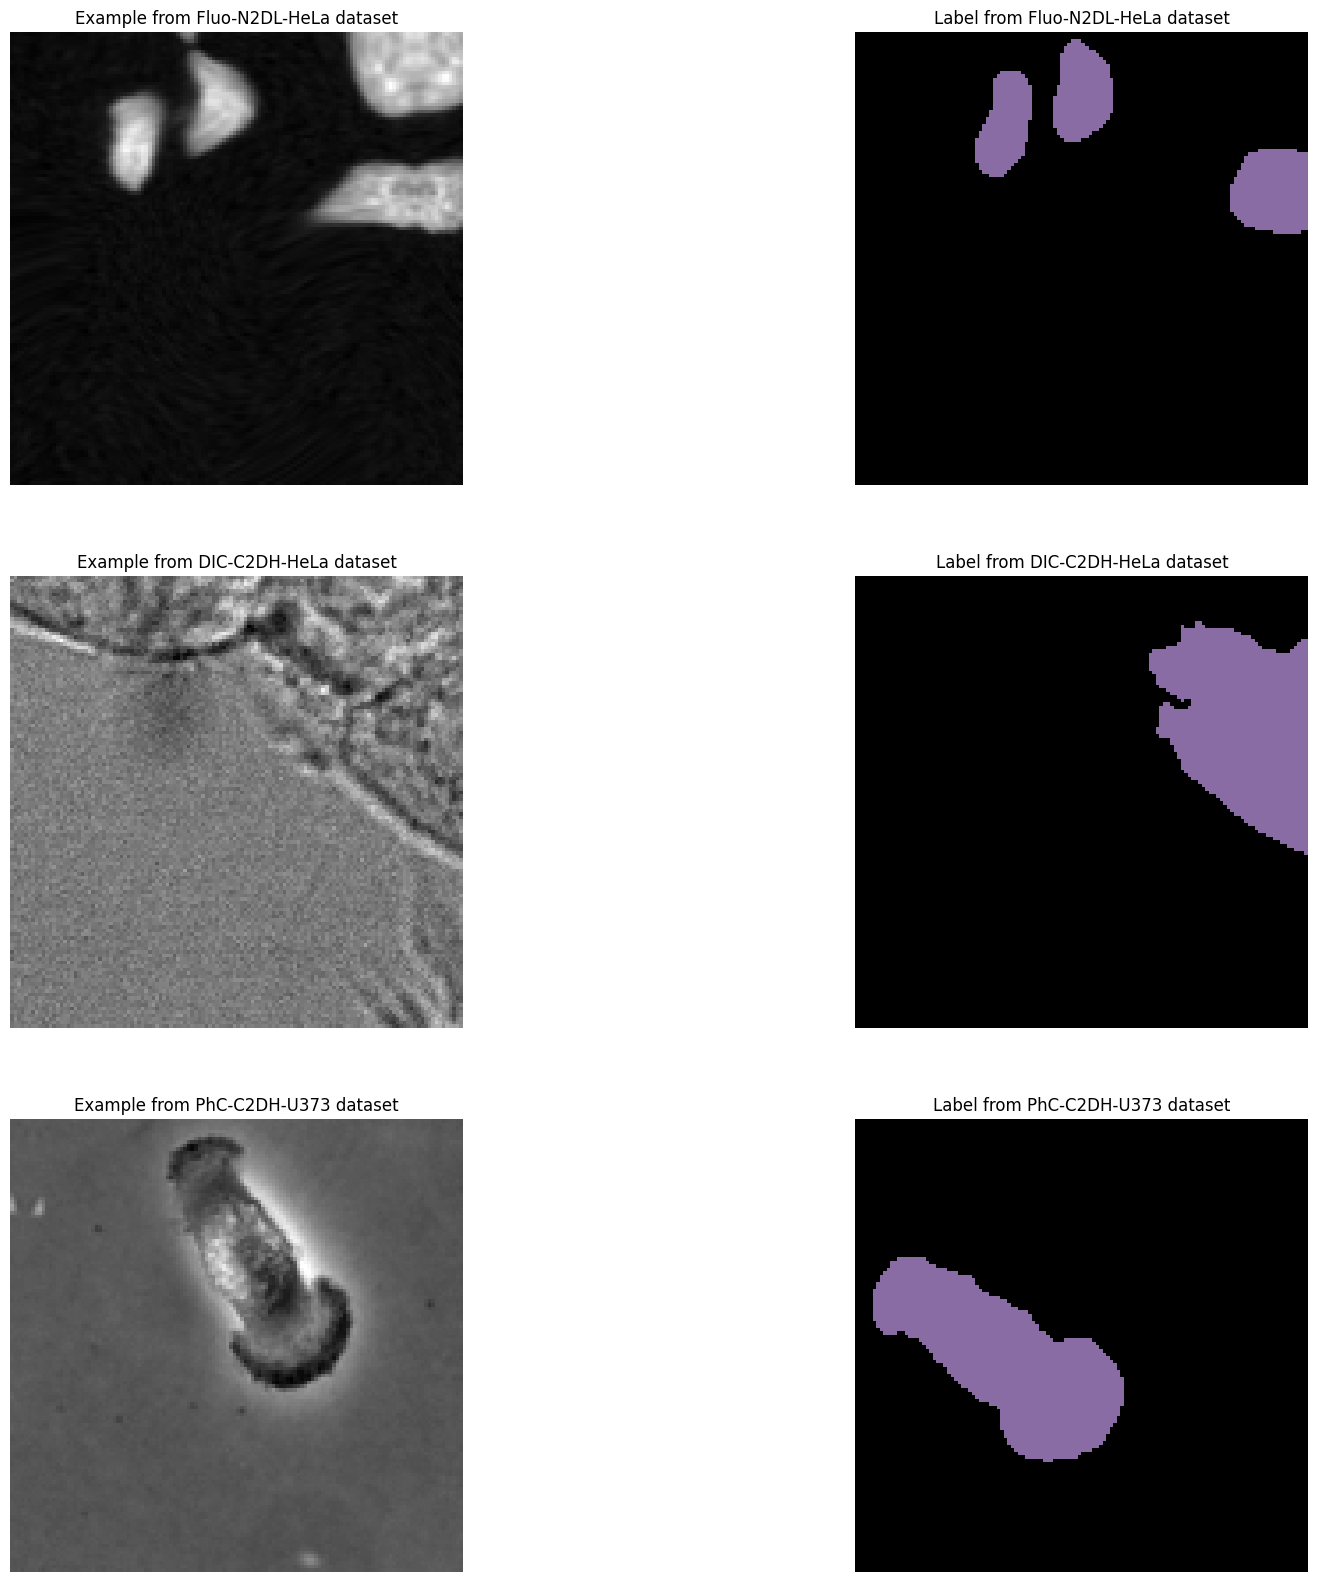

In [59]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

plot_img(axs[0, 0], fluo_data["train"].dataset[2][0], "Example from Fluo-N2DL-HeLa dataset")
plot_mask(axs[0, 1], fluo_data["train"].dataset[2][1], "Label from Fluo-N2DL-HeLa dataset")
plot_img(axs[1, 0], dic_data["train"].dataset[2][0], "Example from DIC-C2DH-HeLa dataset")
plot_mask(axs[1, 1], dic_data["train"].dataset[2][1], "Label from DIC-C2DH-HeLa dataset")
plot_img(axs[2, 0], phc_data["train"].dataset[2][0], "Example from PhC-C2DH-U373 dataset")
plot_mask(axs[2, 1], phc_data["train"].dataset[2][1], "Label from PhC-C2DH-U373 dataset")

plt.show()